In [2]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os
%load_ext memory_profiler
import cProfile

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [3]:
import matplotlib as mpl
# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['axes.edgecolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR
# mpl.rcParams['figure.facecolor'] = '#282C34'
# mpl.rcParams['axes.facecolor'] = '#282C34'
mpl.rcParams['svg.fonttype'] = 'none'
# %matplotlib qt

In [4]:
def plot_power_spectrum(t,spec,xlim,log = True):
    if log: spec = np.log(spec)
    plt.plot(t,spec)
    plt.xlim(xlim)
    
def plot_average_power_spectrum(power,stru):
    col = ['orange','black','green','red']
    for (s,spec),c in zip(power.items(),col):
        f = spec[0]
        spec = spec[1]

        log_spec = np.log(spec)
        mean_log_spec = np.mean(log_spec,0)
        std_log_spec = np.std(log_spec,0)


        plt.plot(f,mean_log_spec,f'{c}')
#         plt.plot(f,mean_log_spec+std_log_spec,f'{c}',linestyle='dashed')
#         plt.plot(f,mean_log_spec-std_log_spec,f'{c}',linestyle='dashed')
        plt.fill_between(f,mean_log_spec+std_log_spec,mean_log_spec-std_log_spec,color=c,alpha = 0.2)
        plt.xlim([0,100])
        plt.ylim([2.5,13])
    plt.legend(power.keys())
    plt.xlabel('Frequency Hz')
    plt.ylabel('Power Spectrum(log)')
    plt.title(f'Power Spectrum In the {stru} \n n_session = {len(spec)}')

In [5]:
def compute_average_spec_state(local_path = 'Rat08/Rat08-20130713',arg = ['BLA',True]):
    
    stru = arg[0]
    plot = arg[1]
    
    bk.load.current_session_linux(local_path = local_path)
    states = bk.load.states()
    pos = bk.load.pos()
    speed = bk.compute.old_speed(pos,20)
    
    low_velocity = bk.compute.toIntervals(speed.index,speed.values<2)
    quiet_wake = states['wake'].intersect(low_velocity)
    quiet_wake = quiet_wake.merge_close_intervals(0.2,time_units = 's')
    quiet_wake = quiet_wake.drop_short_intervals(5,time_units = 's')

    states.update({'quiet_wake':quiet_wake})
    runintervals = bk.load.run_intervals()
    states.update({'run':runintervals})
    del states['drowsy'],states['wake']
    
    
    chan = bk.load.random_channel(stru)
    
    lfps = {}
    for s,interval in states.items():
        lfps.update({s:bk.load.lfp_in_intervals(chan,interval)})

    power_spectrum = {}
    for s,l in lfps.items():
        f,spec = scipy.signal.welch(l.values,fs=1250,nperseg=5000,noverlap=2500)
        power_spectrum.update({s:(f,spec)})
        
    if plot == True:
        plt.figure()
        for s,spec in power_spectrum.items():
            plot_power_spectrum(spec[0],spec[1],[0,100],True)
        plt.legend(power_spectrum.keys())
    
    return power_spectrum

In [6]:
def merge(spec):
    states = ['Rem','sws','quiet_wake','run']
    power_spectrum = {}
    for s in states:
        av = []
        for sess,power_spec in spec.items():
            av.append(power_spec[s][1])
            power_spectrum.update({s:(power_spec[s][0],av)})
    return power_spectrum

In [8]:
bk.load.current_session_linux()

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713


True

In [9]:
average_spec_state_hpc = bk.load.batch(compute_average_spec_state,['Hpc',False],linux = True)
average_spec_state_bla = bk.load.batch(compute_average_spec_state,['BLA',False],linux = True)

100%|██████████| 61/61 [50:24<00:00, 49.57s/it]

Batch finished in 3024.0372354984283
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
37.704918032786885 %


In [11]:
power_hpc = merge(average_spec_state_hpc)
power_bla = merge(average_spec_state_bla)

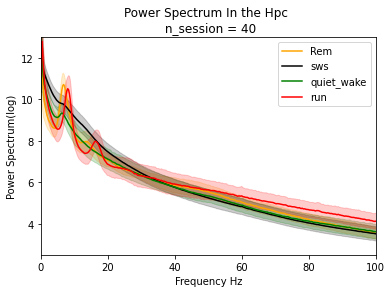

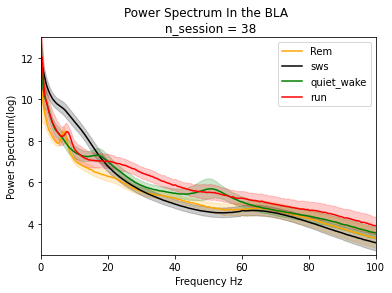

In [13]:
plt.figure()
plot_average_power_spectrum(power_hpc,'Hpc')
plt.savefig(f'/mnt/work/Figures_Gabrielle/average_hpc_power_spec.svg')
plt.show()
plt.figure()
plot_average_power_spectrum(power_bla,'BLA')
plt.savefig(f'/mnt/work/Figures_Gabrielle/average_bla_power_spec.svg')
plt.show()